In [1]:
# -*- coding: utf-8 -*-
import sys
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import torch
import os,pickle
from torch.utils.data.dataloader import DataLoader
from transformers import AutoTokenizer, BertTokenizer
from typing import Dict, List, Tuple, Union
from tqdm import tqdm
from models.model_LADAN_doc_accu_law_term_moco import MoCo
os.chdir('/data/ganleilei/workspace/ContrastiveLJP')


plt.rc('font',family='Times New Roman Cyr')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

SEED=1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
def load_model(model_dir, config, gpu):
    config.HP_gpu = gpu
    print("Load Model from file: ", model_dir)
    model = MoCo(config)
    print(model)
    if config.HP_gpu:
        model = model.cuda()
    ## load model need consider if the model trained in GPU and load in CPU, or vice versa
    # if not gpu:
    #     model.load_state_dict(torch.load(model_dir), map_location=lambda storage, loc: storage)
    #     # model = torch.load(model_dir, map_location=lambda storage, loc: storage)
    # else:
    model.load_state_dict(torch.load(model_dir))
    # model = torch.load(model_dir)

    return model

In [4]:
def evaluate(model, valid_dataloader, name, epoch_idx):

    model.eval()

    ground_accu_y, ground_law_y, ground_term_y  = [], [], []
    predicts_accu_y, predicts_law_y, predicts_term_y = [], [], []   

    accu_features, law_features, term_features = [], [], []
    accu_labels, law_labels, term_labels = [], [], []
    for batch_idx, datapoint in enumerate(valid_dataloader):
        fact_list, raw_fact_lists, accu_label_lists, law_label_lists, term_lists = datapoint
        accu_feats, law_feats, term_feats, accu_preds, law_preds, term_preds = model.forward(
            fact_list, accu_label_lists, law_label_lists, term_lists, 512, 15)

        accu_features.extend(accu_feats.tolist())
        law_features.extend(law_feats.tolist())
        term_features.extend(term_feats.tolist())

        accu_labels.extend(accu_label_lists.tolist())
        law_labels.extend(law_label_lists.tolist())
        term_labels.extend(term_lists.tolist())

        ground_accu_y.extend(accu_label_lists.tolist())
        ground_law_y.extend(law_label_lists.tolist())
        ground_term_y.extend(term_lists.tolist())

        predicts_accu_y.extend(accu_preds.tolist())
        predicts_law_y.extend(law_preds.tolist())
        predicts_term_y.extend(term_preds.tolist())


    return accu_features, law_features, term_features, accu_labels, law_labels, term_labels


In [5]:
from matplotlib import markers


def tsne_plot(features, labels):

    """
    confusing_labels = {1: 0, 4: 1, 14: 2, 29: 3, 108: 4, 111: 5}
    legend = {1: "Pick a Quarrel", 4: "Crowd Fight", 14: "Endangering Public Safety", 29: "Wrongful Death", 108: "Intentional Homicide", 111: "Intentional Injury"}
    """

    confusing_labels = {1: 0, 111: 1, 14: 2}
    legend = {1: "Picking a Quarrel", 111: "Intentional Injury", 14: "Crowd Fight"}
    
    tsne_model = TSNE(n_components=2, random_state=np.random.RandomState(110), learning_rate=1)
    plt.figure(figsize=(10, 10))
    ax1 = plt.axes(frameon=False)
    ax1.get_xaxis().tick_bottom()
    ax1.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.legend(markerscale=10)

    x = np.arange(3)
    ys = [i+x+(i*x)**2 for i in range(3)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    marks = ['o', 'v', '^', 's', 'p', '<', '>', '1', '2', '3', '4', '*'][:3]

    tokens, token_labels = [], []

    for (item, label) in zip(features, labels):
        if label not in confusing_labels.keys():
            continue

        tokens.append(item)
        token_labels.append(label)
    
    print("Begin tsne model!")
    new_values = tsne_model.fit_transform(tokens)
    print("New values type:", new_values.shape)
    print("Finish tsne model!")
    
    marker_size=45

    for k, v in confusing_labels.items():
        print("confusing labels:", k)
        x, y = [], []
        for idx in range(len(token_labels)):
            if token_labels[idx] != k: continue

            x.append(new_values[idx][0])
            y.append(new_values[idx][1])
        
        plt.scatter(x, y, marker=marks[v], color=colors[v], s=marker_size, label=legend[k])
    
    plt.legend(loc="best", fontsize=15)
    plt.savefig('ladan_accu_3390.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [6]:
def load_data_setting(save_file):
    with open(save_file, 'rb') as fp:
        data = pickle.load(fp)
    print("Data setting loaded from file: ", save_file)
    data.show_data_summary()
    return data

In [7]:
def load_dataset(path):
    train_path = os.path.join(path, "train_processed_thulac_Legal_basis_with_fyb_annotate_number_field.pkl")
    valid_path = os.path.join(path, "valid_processed_thulac_Legal_basis_with_fyb_annotate_number_field.pkl")
    test_path = os.path.join(path, "test_processed_thulac_Legal_basis_with_fyb_annotate_number_field.pkl")
    
    train_dataset = pickle.load(open(train_path, mode='rb'))
    valid_dataset = pickle.load(open(valid_path, mode='rb'))
    test_dataset = pickle.load(open(test_path, mode='rb'))

    print("train dataset sample len:", len(train_dataset['law_label_lists']))
    return train_dataset, valid_dataset, test_dataset

In [8]:
from torch.utils.data.dataset import Dataset
class LADANDataset(Dataset):

    def __init__(self, data, tokenizer, max_len, id2word_dict):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = data
        self.id2word_dict = id2word_dict

    def __len__(self):
        return len(self.data['fact_list'])

    def __getitem__(self, index):
        fact_list = self.data['fact_list'][index]
        raw_fact_list = self.data['raw_facts_list'][index] 
        accu_label_lists = self.data['accu_label_lists'][index]
        law_label_lists = self.data['law_label_lists'][index]
        term_lists = self.data['term_lists'][index]
        
        return fact_list, raw_fact_list, accu_label_lists, law_label_lists, term_lists 

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def collate_ladan_fn(batch):
    
    batch_fact_list, batch_raw_fact_list, batch_law_label_lists, batch_accu_label_lists, batch_term_lists = [], [], [], [], []
    for item in batch:
        batch_fact_list.append(item[0])
        batch_raw_fact_list.append(item[1])
        batch_accu_label_lists.append(item[2])
        batch_law_label_lists.append(item[3])
        batch_term_lists.append(item[4])

    padded_fact_list = torch.LongTensor(batch_fact_list).to(DEVICE)
    padded_accu_label_lists = torch.LongTensor(batch_accu_label_lists).to(DEVICE)
    padded_law_label_lists = torch.LongTensor(batch_law_label_lists).to(DEVICE)
    padded_term_lists = torch.LongTensor(batch_term_lists).to(DEVICE)

    return padded_fact_list, batch_raw_fact_list, padded_accu_label_lists, padded_law_label_lists, padded_term_lists

In [ ]:
from train_ladan_doc_accu_law_term_moco import Config

bert_path = "/data/ganleilei/bert/bert-base-uncased/"
model_path = "/data/ganleilei/law/ContrastiveLJP/results/LADAN/LADAN_doc_accu_law_term_moco/alpha3.0_beta3.0_gama9.0_theta0.0/10/"
data_path = "/data/ganleilei/law/ContrastiveLJP/datasets/fyb_annotate/"
savedset_path = os.path.join(model_path, "data.dset")
config = load_data_setting(savedset_path)
tokenizer = AutoTokenizer.from_pretrained(bert_path)
train_data, valid_data, test_data = load_dataset(data_path)
train_dataset = LADANDataset(train_data, tokenizer, config.MAX_SENTENCE_LENGTH, config.id2word_dict)
valid_dataset = LADANDataset(valid_data, tokenizer, config.MAX_SENTENCE_LENGTH, config.id2word_dict)
test_dataset = LADANDataset(test_data, tokenizer, config.MAX_SENTENCE_LENGTH, config.id2word_dict)

train_dataloader = DataLoader(train_dataset, batch_size=config.HP_batch_size, shuffle=False, collate_fn=collate_ladan_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=config.HP_batch_size, shuffle=False, collate_fn=collate_ladan_fn)
test_dataloader = DataLoader(test_dataset, batch_size=config.HP_batch_size, shuffle=False, collate_fn=collate_ladan_fn)
model_path = os.path.join(model_path, "best.ckpt")
model = load_model(model_path, config, True)
accu_features, law_features, term_features, accu_labels, law_labels, term_labels = evaluate(model, test_dataloader, "Test", 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Begin tsne model!
New values type: (1845, 2)
Finish tsne model!
confusing labels: 1
confusing labels: 111
confusing labels: 14


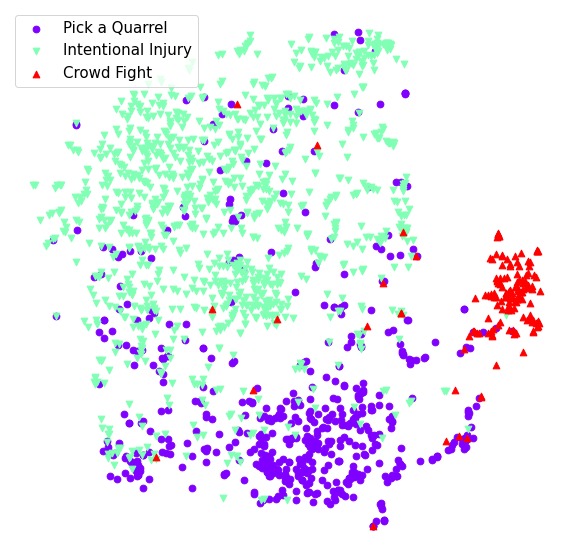

In [30]:
tsne_plot(accu_features, accu_labels)